In [1]:
import pandas as pd
import numpy as np
# from utilities.gex_parser import parse_gex_file
import matplotlib.pyplot as plt

In [5]:
# Start with just importing the time domain module of simpeg, and a utility to plot a layered model.
import simpeg.electromagnetics.time_domain as tdem

from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
    inversion,
)

from simpeg.data_misfit import L2DataMisfit

from discretize import TensorMesh

# Load data from .csv

In [14]:
file_path = "Data/AusAEM_WA_Block_E_EM.csv"
df = pd.read_csv(file_path, 
                 #delim_whitespace=True,
                 delimiter=",") 
                 #sep=r'\s+', 
                 #comment='#') #delimiter="\t")#, comment='#')  # Ignore headers if marked with '#'

/var/folders/nv/3rmg65wj733gdy4gk5sxm8cc0000gn/T/ipykernel_15067/1153179109.py:2: DtypeWarning: Columns (153,154,156,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,


In [16]:
# take a look of the dataframe/
df.head()

,GA_Project,Job_No,Fiducial,Line,Flight,DateTime,Date_UTC,Time_UTC,What,Date_Local,...,RUNC_HM_Z_19,RUNC_HM_Z_20,RUNC_HM_Z_21,RUNC_HM_Z_22,RUNC_HM_Z_23,MA1,BMAG,TMI,IGRF,TMI_IGRF
0,100101,5002,10079,43500879,100101,20210827.01,44435.00509,20210827,719.5,20210827.1,...,3.95584,6.45271,4.14097,37.22344,2.98606,57747.00,58335.57,57744.43,57898.01,58179.42
1,100101,5002,10079,43500880,100101,20210827.01,44435.00509,20210827,720.0,20210827.0,...,4.37806,7.87759,4.43024,25.36838,2.89718,57748.45,58335.57,57745.88,57898.02,58180.87
2,100101,5002,10079,43500881,100101,20210827.01,44435.00510,20210827,720.5,20210827.0,...,4.73999,8.92172,4.52947,16.99572,2.85546,57749.54,58335.57,57746.96,57898.02,58181.94
3,100101,5002,10079,43500882,100101,20210827.01,44435.00510,20210827,721.0,20210827.0,...,5.14875,9.81910,4.50944,11.99612,2.85190,57749.98,58335.58,57747.40,57898.02,58182.38
4,100101,5002,10079,43500883,100101,20210827.01,44435.00511,20210827,721.5,20210827.0,...,5.47572,10.91546,4.44444,9.06249,2.87407,57749.75,58335.58,57747.16,57898.01,58182.15


In [18]:
# Replace invalid values (-99999999) with NaN
df.replace(-99999999, np.nan, inplace=True)
df.replace(0, np.nan, inplace=True)
# Drop rows with missing values
df.dropna(inplace=True)

In [22]:
#filter data of flight lines 101102 and 101201
df_101102 = df[df["GA_Project"] == 101102]
df_101201 = df[df["GA_Project"] == 101201]

In [26]:
# extract lat, lon, easting, northing, Z-comp LM dB/dt processed and normalised, Z-comp HM dB/dt processed and normalised, 
# Z-comp LM dB/dt relative uncertainty, Z-comp HM dB/dt relative uncerttainty

# lat, lon (WGS84)
lat=df_101102["Latitude"]
lon=df_101102["Longitude"]

# easting, northing (GDA2020 MGA Zone 50)
easting=df_101102["Easting"]
northing=df_101102["Northing"]

# z component Low Moment, High Moment 
LM_Z=df_101102.iloc[:, 65:83]*1e-12
HM_Z=df_101102.iloc[:, 83:106]*1e-12

# z component relative uncertainty Low Moment, High Moment
RUNC_LM_Z=df_101102.iloc[:, 106:124]
RUNC_HM_Z=df_101102.iloc[:, 124:147]


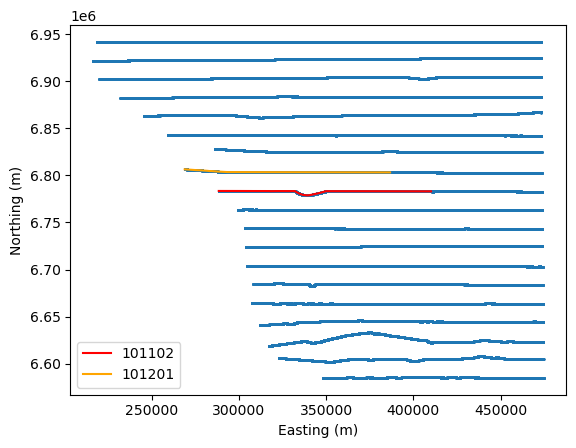

In [28]:
# plot all flight lines and selected flight lines

plt.scatter(df["Easting"], df["Northing"], s=0.5)
plt.plot(easting, northing, label="101102", c="r")
plt.plot(df_101201["Easting"], df_101201["Northing"], label="101201", c="orange")
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend()
plt.show()

In [30]:
# Normalize LM_Z and HM_Z by dividing by their peak values
# Provided data are normalized. 

# LM_Z_norm = LM_Z / LM_Z.max()
# HM_Z_norm = HM_Z / HM_Z.max()

# Starting with single station (sounding)

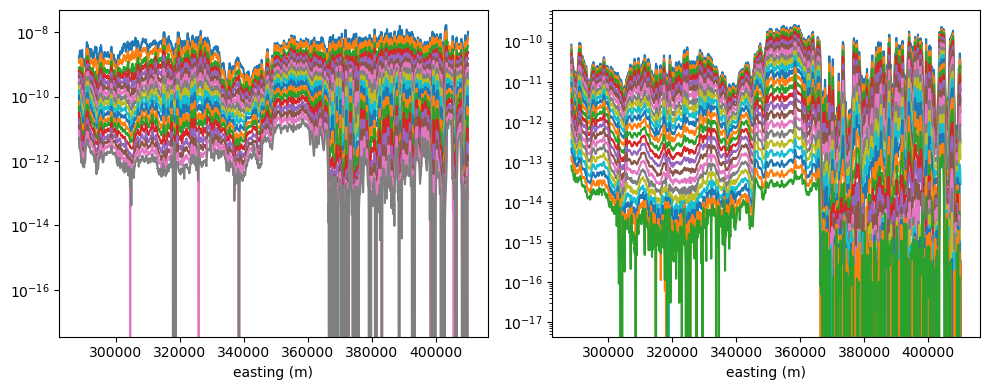

In [33]:
# look at the data
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].semilogy(easting, LM_Z)
ax[0].set_xlabel('easting (m)')
#ax[0].set_ylim(1e-5, 1e5)

ax[1].semilogy(easting, HM_Z)
ax[1].set_xlabel('easting (m)')

plt.tight_layout()

In [35]:
# Select a single sounding along that line, and grab all of the data associated with that station
# Record 5999
station = df_101102[5999:6000]
station_lm_data = station.iloc[0, 65:83].to_numpy()*1e-12
#station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates].to_numpy()
station_hm_data = station.iloc[0, 83:106].to_numpy()*1e-12
#station_hm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:].to_numpy()

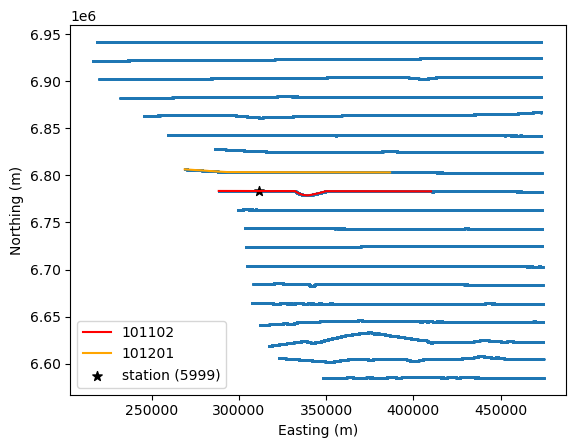

In [41]:
# show selected station
plt.scatter(df["Easting"], df["Northing"], s=0.5)
plt.plot(easting, northing, label="101102", c="r")
plt.plot(df_101201["Easting"], df_101201["Northing"], label="101201", c="orange")
plt.scatter(station["Easting"], station["Northing"], c="k", marker="*", label="station (5999)", s=50)
#plt.scatter(line.UTMX, line.UTMY, s=0.5)
#plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.legend()
plt.show()

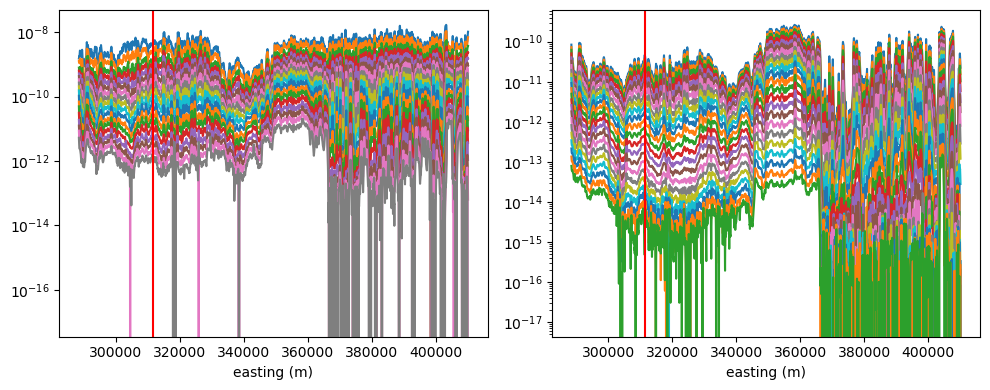

In [42]:
# look at the data
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].semilogy(easting, LM_Z)
ax[0].set_xlabel('easting (m)')
ax[0].axvline(station.iloc[0, 17], c="r")
#ax[0].set_ylim(1e-5, 1e5)

ax[1].semilogy(easting, HM_Z)
ax[1].set_xlabel('easting (m)')
ax[1].axvline(station.iloc[0, 17], c="r")

plt.tight_layout()

In [45]:
# load the gate opening time for LM and HM respectively
LM_excel = "Data/LM_times.csv"
HM_excel = "Data/HM_times.csv"
LM_times_csv = pd.read_csv(LM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_times_csv = pd.read_csv(HM_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [49]:
# extract gate_centre (s)
LM_times = LM_times_csv["Gate Centre (s)"].to_numpy()
HM_times = HM_times_csv["Gate Centre (s)"].to_numpy()

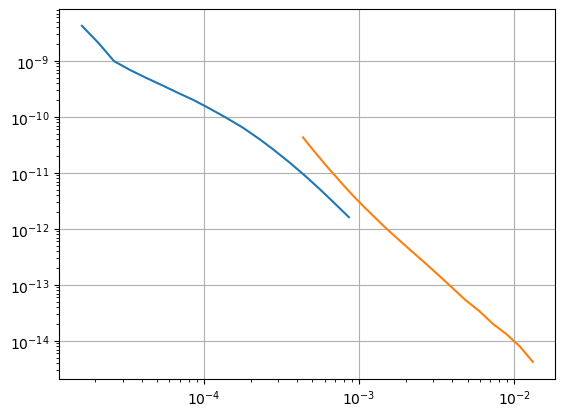

In [51]:
# plot data for single station (1999)
plt.loglog(LM_times, station_lm_data)
plt.loglog(HM_times, station_hm_data)
plt.grid()

# Setting up survey

In [53]:
LM_waveform_excel = "Data/LM_waveform.csv"
HM_waveform_excel = "Data/HM_waveform.csv"
LM_waveform_csv = pd.read_csv(LM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 
HM_waveform_csv = pd.read_csv(HM_waveform_excel, 
                 #delim_whitespace=True,
                 delimiter=",") 

In [26]:
# extract the time and form from waveform_csv 
LM_wave_time = LM_waveform_csv["Time (s)"]
LM_wave_form = LM_waveform_csv["Amplitude"]
HM_wave_time = HM_waveform_csv["Time (s)"]
HM_wave_form = HM_waveform_csv["Amplitude"]

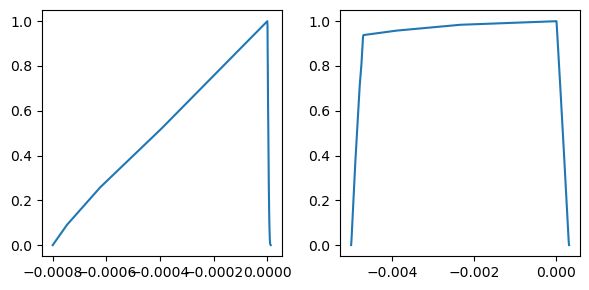

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
ax[0].plot(LM_wave_time, LM_wave_form)
ax[1].plot(HM_wave_time, HM_wave_form)
plt.tight_layout()

In [99]:
# shape of the transmitter, and the offset of the receiver coil.
tx_shape = np.array([[-12.64,  -2.13,   0.  ],
       [ -6.15,  -8.59,   0.  ],
       [  5.74,  -8.59,   0.  ],
       [ 11.13,  -3.19,   0.  ],
       [ 11.13,   3.19,   0.  ],
       [  5.74,   8.59,   0.  ],
       [ -6.15,   8.59,   0.  ],
       [-12.64,   2.13,   0.  ],
       [-12.64,  -2.13,   0.  ]])
rx_offset = np.array([-13.25,   0.  ,  -2.  ])

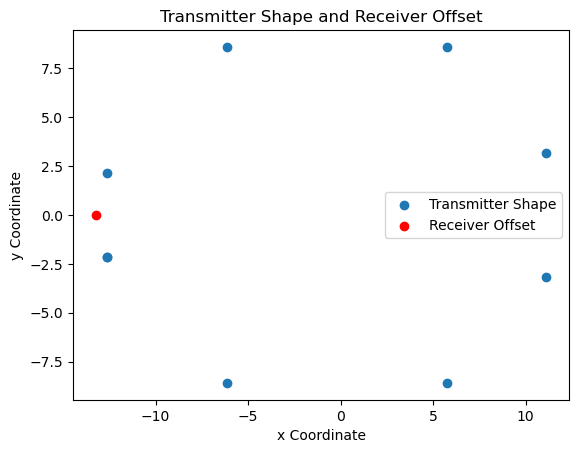

In [29]:
# Extract x and y coordinates for transmitter shape
tx_x = [point[0] for point in tx_shape]
tx_y = [point[1] for point in tx_shape]

# Scatter plot for transmitter shape
plt.scatter(tx_x, tx_y, label='Transmitter Shape')

# Scatter plot for receiver offset
plt.scatter(rx_offset[0], rx_offset[1], label='Receiver Offset', color='red')

# Add labels and legend
plt.xlabel('x Coordinate')
plt.ylabel('y Coordinate')
plt.title('Transmitter Shape and Receiver Offset')
plt.legend()

# Show the plot
plt.show()

In [135]:
# add UTM coordinates to transmitter shape and the receiver offset
# tx_loc = tx_shape + [311527.56, 6783344.30, station["GPS_Alt"].iloc[0]]
tx_loc = tx_shape + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["GPS_Alt"].iloc[0]] # 17 is easting, 18 is northing, 19 is altitude of Tx loop
rx_loc = rx_offset + [station["Easting"].iloc[0], station["Northing"].iloc[0], station["GPS_Alt"].iloc[0]]
tx_area=342.0 # from data processing report

In [293]:
# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, LM_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(LM_wave_time, LM_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

In [295]:
# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, HM_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(HM_wave_time, HM_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

In [297]:
srv = tdem.Survey([src_lm, src_hm])
srv_lm = tdem.Survey(src_lm)
srv_hm = tdem.Survey(src_hm)

In [299]:
#first a simple test
thicknesses = []
conductivities = [1e-1]

In [301]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

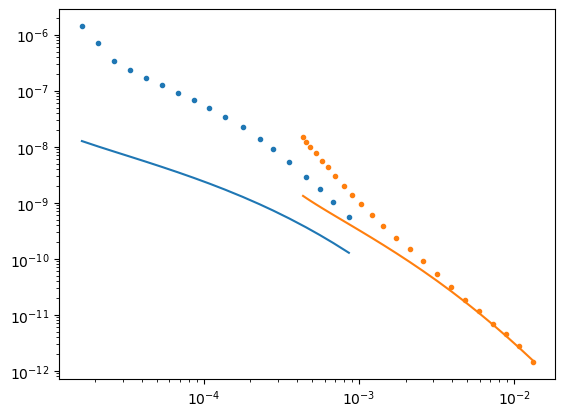

In [303]:
# sim.thicknesses = [5]
# sim.sigma = [3E-1]
pre = -sim.dpred(None)
pre_lm = pre[:18]
pre_hm = pre[18:]

plt.loglog(LM_times, pre_lm)
plt.loglog(HM_times, pre_hm)
plt.loglog(LM_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='')
plt.loglog(HM_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='')

# Set up inversion for single station

In [305]:
# map
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

In [306]:
# noise std? = uncertainties
station_lm_std = station.iloc[0, 147: 165].to_numpy()
station_hm_std = station.iloc[0, 165: 188].to_numpy()

In [310]:
# observed data (normalised) & relative errors 
dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
rel_err = np.r_[station_lm_std, station_hm_std]

# Convert 'dobs' to a proper numeric array
dobs = np.array(dobs, dtype=np.float64)  # Force float64 conversion

# Ensure no NaN or infinite values
dobs = np.nan_to_num(dobs, nan=1e-10, posinf=1e-10, neginf=-1e-10)

# Convert 'rel_err' to a proper numeric array
rel_err = np.array(rel_err, dtype=np.float64)  # Ensure float64 type

# Handle NaN or invalid values
rel_err = np.nan_to_num(rel_err, nan=1e-10, posinf=1e-10, neginf=1e-10)

# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

data_container = data.Data(srv, dobs=dobs, relative_error=uncertainties) # method 2 to obtain data_object
# data_container = data.Data(srv, dobs=dobs, relative_error=rel_err) # method 1 to obtain data_object

In [466]:
# try with lm data only

# observed data (normalised) & relative errors 
dobs_lm = -tx_area * np.r_[station_lm_data]
rel_err_lm = np.r_[station_lm_std]

# Convert 'dobs' to a proper numeric array
dobs_lm = np.array(dobs_lm, dtype=np.float64)  # Force float64 conversion

# Ensure no NaN or infinite values
dobs_lm = np.nan_to_num(dobs_lm, nan=1e-10, posinf=1e-10, neginf=-1e-10)

# Convert 'rel_err' to a proper numeric array
rel_err_lm = np.array(rel_err_lm, dtype=np.float64)  # Ensure float64 type

# Handle NaN or invalid values
rel_err_lm = np.nan_to_num(rel_err_lm, nan=1e-10, posinf=1e-10, neginf=1e-10)

# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs_lm) * np.ones(np.shape(dobs_lm))

# calculate absolute uncertainty by relative uncertainty * LM_Z 
# abs_uncertainties = -rel_err_lm * dobs_lm

# data_container_lm = data.Data(srv_lm, dobs=dobs_lm, relative_error=uncertainties) # method 2 to obtain data_object
data_container_lm = data.Data(srv_lm, dobs=dobs_lm, relative_error=rel_err_lm) # method 1 to obtain data_object

In [506]:
# try with hm data only

# observed data (normalised) & relative errors 
dobs_hm = -tx_area * np.r_[station_hm_data]
rel_err_hm = np.r_[station_hm_std]

# Convert 'dobs' to a proper numeric array
dobs_hm = np.array(dobs_hm, dtype=np.float64)  # Force float64 conversion

# Ensure no NaN or infinite values
dobs_hm = np.nan_to_num(dobs_hm, nan=1e-10, posinf=1e-10, neginf=-1e-10)

# Convert 'rel_err' to a proper numeric array
rel_err_hm = np.array(rel_err_hm, dtype=np.float64)  # Ensure float64 type

# Handle NaN or invalid values
rel_err_hm = np.nan_to_num(rel_err_hm, nan=1e-10, posinf=1e-10, neginf=1e-10)

# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs_hm) * np.ones(np.shape(dobs_hm))

# calculate absolute uncertainty by relative uncertainty * LM_Z 
# abs_uncertainties = -rel_err_lm * dobs_lm

# data_container_lm = data.Data(srv_lm, dobs=dobs_lm, relative_error=uncertainties) # method 2 to obtain data_object
data_container_hm = data.Data(srv_hm, dobs=dobs_hm, relative_error=rel_err_hm) # method 1 to obtain data_object

In [508]:
station_hm_std

array([0.00061, 0.00057, 0.00053, 0.00036, 0.00047, 0.00061, 0.00052,
       0.00078, 0.00111, 0.00129, 0.00174, 0.00249, 0.0036, 0.00573,
       0.00862, 0.01393, 0.02318, 0.03774, 0.05801, 0.09477, 0.13769,
       0.22108, 0.41351], dtype=object)

In [510]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.1

# minimum diffusion distance
d_min = 1250 * np.sqrt(HM_times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(LM_times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 82.5771419643475 m
MAXIMUM DIFFUSION DISTANCE: 116.01555660772395 m


In [511]:
depth_min = 1  # top layer thickness
depth_max = 400.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [512]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers

In [516]:
n_layers

31

In [518]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [520]:
# Starting model is log-conductivity values (S/m)
starting_conductivity_model = np.log(1e-1 * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_conductivity_model = starting_conductivity_model.copy()

In [522]:
simulation_L2_hm = tdem.Simulation1DLayered(
    survey=srv_hm, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

In [524]:
dmis_L2_hm = data_misfit.L2DataMisfit(simulation=simulation_L2_hm, data=data_container_hm)

In [526]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 31 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     31       -492.32          0.00      1.00     57.58    1.15




In [528]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

In [530]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

In [532]:
inv_prob_L2_hm = inverse_problem.BaseInvProblem(dmis_L2_hm, reg_L2, opt_L2)

In [534]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=False)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, starting_beta, beta_schedule, target_misfit]

In [536]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2_hm, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_conductivity_model)


Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.71e+02  2.30e+07  0.00e+00  2.30e+07    8.85e+05      0              
   1  2.71e+02  1.98e+07  9.23e+02  2.01e+07    7.70e+05      2              
   2  2.71e+02  1.86e+07  1.60e+03  1.90e+07    7.75e+05      2              
   3  1.35e+02  1.82e+07  2.22e+03  1.85e+07    1.12e+06      1              
   4  1.35e+02  1.74e+07  2.53e+03  1.78e+07    3.94e+05      2              
   5  1.35e+02  1.73e+07  2.87e+03  1.77e+07    7.39e+05      2   Skip B

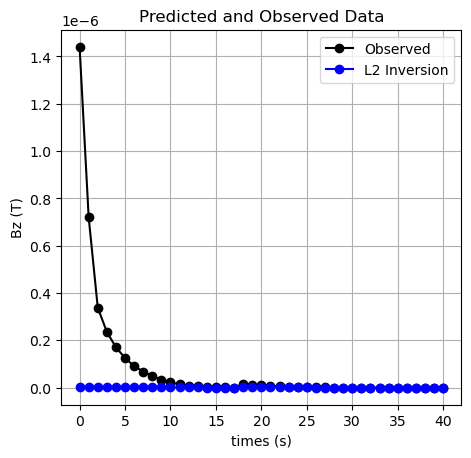

In [537]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.plot(np.abs(dobs), "k-o")
ax1.plot(np.abs(dpred_L2), "b-o")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="upper right")
plt.show()

In [277]:
dpred_L2.shape

(41,)

In [143]:
# parametric halfspace inversion
sim_inv1 = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)

In [145]:
sim_inv1.model = np.log(np.r_[1E-5])
sim_inv1.sigma

array([1.e-05])

In [147]:
phi_d_1 = L2DataMisfit(data=data_container, simulation=sim_inv1)

TypeError: Object must be an instance of Data for data

In [62]:
# 3% of the absolute value
uncertainties = 0.03 * np.abs(dobs) * np.ones(np.shape(dobs))

# Define the data object
data_object = data.Data(srv, dobs=dobs, standard_deviation=uncertainties) # method 2 to obtain data_object

In [43]:
# define 1D layered earth

# Layer thicknesses
inv_thicknesses = np.logspace(0, 1.5, 25)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")

In [44]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(0.1 * np.ones(mesh.nC))

# Define mapping from model to active cells.
model_mapping = maps.ExpMap()

In [45]:
simulation = tdem.Simulation1DLayered(
    survey=srv, thicknesses=inv_thicknesses #sigmaMap=exp_map
)

In [52]:
print(type(reg_map))

<class 'simpeg.maps._base.IdentityMap'>


In [50]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1.0 / uncertainties

# Define the regularization (model objective function)
reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.Sparse(mesh, mapping=reg_map, alpha_s=0.01, alpha_x=1.0)

# set reference model
reg.reference_model = starting_model

# Define sparse and blocky norms p, q
reg.norms = [1, 0]

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(maxIter=100, maxIterLS=20, maxIterCG=30, tolCG=1e-3)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# 
#inv = inversion.BaseInversion(inv_prob, directiveList=directiveList)
#m0 = np.log(np.ones(mtrue.size)*sig_half)
#
#prbTD.counter = opt.counter = Utils.Counter()
#opt.remember('xc')



In [ ]:

# Run inversion
recovered_model = inv.run(m_0)